In [83]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import functions
import numpy as np
import math, pyarrow.parquet as pq, os, glob
import pandas as pd

In [84]:
# Cell 2: читаем паркет один раз
df, odf = functions.read_files(
    '2025-07-15','2025-07-21'
)
odf['recv_time'] = pd.to_datetime(odf['recv_time'])


In [85]:
import time

if 'recv_time' not in df.columns:
    df = df.reset_index()
    
# считаем индикаторы
strat_time = time.time()

PERIOD_BIG = '1h'
PERIOD_SMALL = '15min'
STEP   = 0.5
va_df      = functions.value_area(df.copy(), PERIOD_BIG, STEP)
delta      = functions.volume_delta(df.copy(), PERIOD_BIG).rename('volume_delta')
vpin       = functions.VPIN(df.copy(), PERIOD_SMALL, functions.BUCKET_SIZE, functions.WINDOW_LENGTH)
ofi        = functions.process_order_flow_imbalance(odf, PERIOD_SMALL)
rf         = functions.RF(va_df)
kyle_lambda= functions.vectorized_kyle_lambda(df.copy(), PERIOD_BIG)
cum_delta  = functions.cummulutive_delta(df.copy(), PERIOD_BIG)

end_time = time.time()

price_bar = (
    df.set_index('recv_time')['price']
      .resample(PERIOD_BIG)
      .last()            # закрытие бара
      .ffill()           # если бар пустой — дублируем предыдущее значение
      .rename('price')
)

# 2) Объединяем с вашим indicators_df
indicators_df = pd.concat(
    [va_df, delta, vpin, rf, ofi, kyle_lambda, cum_delta], axis=1
).join(price_bar, how='left')

to_fill = ['POC_price','POC_volume','VAH','VAL','RF','volume_delta','cum_delta','Kyle_Lambda']
indicators_df[to_fill] = indicators_df[to_fill].ffill()

print(indicators_df.head(10))
print(f'время подсчета {end_time-strat_time} секунд')


                     POC_price  POC_volume       VAH       VAL  volume_delta  \
2025-07-15 14:00:00   116200.0  469.634001  117409.5  115912.0  -2306.872006   
2025-07-15 14:15:00   116200.0  469.634001  117409.5  115912.0  -2306.872006   
2025-07-15 14:30:00   116200.0  469.634001  117409.5  115912.0  -2306.872006   
2025-07-15 14:45:00   116200.0  469.634001  117409.5  115912.0  -2306.872006   
2025-07-15 15:00:00   116150.0   93.841000  116474.0  115934.5    404.967001   
2025-07-15 15:15:00   116150.0   93.841000  116474.0  115934.5    404.967001   
2025-07-15 15:30:00   116150.0   93.841000  116474.0  115934.5    404.967001   
2025-07-15 15:45:00   116150.0   93.841000  116474.0  115934.5    404.967001   
2025-07-15 16:00:00   116430.0   95.630000  117449.0  116416.0   -442.808999   
2025-07-15 16:15:00   116430.0   95.630000  117449.0  116416.0   -442.808999   

                         VPIN        RF           OFI  Kyle_Lambda  \
2025-07-15 14:00:00  0.268605       NaN -1.364119

подсчет сигналов и выбор timestamp

In [96]:
# rf = indicators_df['RF']
# vpin = indicators_df['VPIN']
# ofi = indicators_df['OFI']
# kl = indicators_df['Kyle_Lambda']
# vol_del = indicators_df['volume_delta']
# price = indicators_df['price']

'''-----------------------пересечение цены VAH или VAL-----------------------'''
P = indicators_df['price']
H = indicators_df['VAH']
L = indicators_df['VAL']

P_prev = P.shift(1)
H_prev = H.shift(1)
L_prev = L.shift(1)

indicators_df['VAH_sell']  = (P <  H) & (P_prev >= H_prev)

indicators_df['VAL_buy'] = (P >  L) & (P_prev <= L_prev)
'''--------------------------------------------------------------------------'''

'''-----------------------rotation factor-----------------------'''
rf_z = (indicators_df['RF'] - indicators_df['RF'].rolling(96).mean()) / indicators_df['RF'].rolling(96).std()
rf_buy  = rf_z < -1    # нижнее 16 %
rf_sell = rf_z > +1

indicators_df['rf_buy'] = rf_buy.fillna(False)
indicators_df['rf_sell'] = rf_sell.fillna(False)
'''--------------------------------------------------------------'''

'''-----------------------kyle's lambda-----------------------'''
# kl_buy = kl < 0.05
# kl_sell = kl > 0.2

# indicators_df['kl_buy'] = kl_buy.fillna(False)
# indicators_df['kl_sell'] = kl_sell.fillna(False)
'''--------------------------------------------------------------'''

'''-----------------------изменение ofi с отрицательного на положительное-----------------------'''
ofi_buy = (
    (indicators_df['OFI'] >= 0) &
    (indicators_df['OFI'].shift(1) <= -2)
)

ofi_sell = (
    (indicators_df['OFI'] <= 0) &
    (indicators_df['OFI'].shift(1) >= 2)
)

indicators_df['ofi_buy'] = ofi_buy.fillna(False)
indicators_df['ofi_sell'] = ofi_sell.fillna(False)
'''---------------------------------------------------------------------------------------------'''

'''-----------------------изменение volume delta-----------------------'''
abs_delta = indicators_df['volume_delta'].abs()

avg_delta = abs_delta.rolling(24).mean()

indicators_df['vol_buy']  = (indicators_df['volume_delta'] >  avg_delta).fillna(False)
indicators_df['vol_sell'] = (indicators_df['volume_delta'] < -avg_delta).fillna(False)
'''------------------------------------------------------------------------------------------------------'''

open_pos_long = (
    # indicators_df['ofi_buy'] &
    indicators_df['vol_del_buy'] &
    indicators_df['rf_buy'] 
    # indicators_df['kl_buy'] &
    # indicators_df['VAL_buy']
)

close_pos_long = (
    # indicators_df['ofi_sell'] &
    indicators_df['vol_del_sell'] &
    indicators_df['rf_sell'] 
    # indicators_df['kl_sell'] &
    # indicators_df['VAH_sell']
)

# open_pos_short = close_pos_long
# close_pos_short = open_pos_long

#открытие и закрытие позиций
longs_open  = indicators_df.index[ open_pos_long.fillna(False) ].unique()
longs_close = indicators_df.index[ close_pos_long.fillna(False) ].unique()
print(longs_open, longs_close)

# shorts_open  = longs_close
# shorts_close = longs_open
#OFI > 5 -- КУПИТЬ < -5 ==

DatetimeIndex(['2025-07-20 00:00:00', '2025-07-20 00:15:00',
               '2025-07-20 00:30:00', '2025-07-20 00:45:00',
               '2025-07-20 01:00:00', '2025-07-20 01:15:00',
               '2025-07-20 01:30:00', '2025-07-20 01:45:00',
               '2025-07-20 03:00:00', '2025-07-20 03:15:00',
               '2025-07-20 03:30:00', '2025-07-20 03:45:00',
               '2025-07-20 04:00:00', '2025-07-20 04:15:00',
               '2025-07-20 04:30:00', '2025-07-20 04:45:00',
               '2025-07-20 06:00:00', '2025-07-20 06:15:00',
               '2025-07-20 06:30:00', '2025-07-20 06:45:00',
               '2025-07-20 07:00:00', '2025-07-20 07:15:00',
               '2025-07-20 07:30:00', '2025-07-20 07:45:00',
               '2025-07-20 08:00:00', '2025-07-20 08:15:00',
               '2025-07-20 08:30:00', '2025-07-20 08:45:00',
               '2025-07-20 10:00:00', '2025-07-20 10:15:00',
               '2025-07-20 10:30:00', '2025-07-20 10:45:00',
               '2025-07-

соотнесение временных меток с ценами и создания списков трейдов

In [97]:
# --- Подготовка ts/pr ---
ts = df['recv_time'].astype(np.int64).to_numpy()
pr = df['price'].to_numpy()

# --- Переводим времена в наносекунды для всех сигналов ---
events = {
    'long': {
        'open_idx': longs_open,
        'close_idx': longs_close,
    },
    # 'short': {
    #     'open_idx': shorts_open,
    #     'close_idx': shorts_close,
    # }
}

# --- Интерполируем цены для каждого события ---
for direction, ev in events.items():
    ev['open_ns']  = ev['open_idx'].astype(np.int64)
    ev['close_ns'] = ev['close_idx'].astype(np.int64)
    ev['open_pr']  = np.interp(ev['open_ns'],  ts, pr)
    ev['close_pr'] = np.interp(ev['close_ns'], ts, pr)

# --- Матчим и собираем все трейды с признаком direction ---
trades = []
for direction, ev in events.items():
    opens, closes = ev['open_idx'], ev['close_idx']
    op_pr, cl_pr  = ev['open_pr'],  ev['close_pr']
    i = j = 0
    while i < len(opens) and j < len(closes):
        t_o, t_c = opens[i], closes[j]
        if t_c <= t_o:
            j += 1
            continue
        entry, exit_ = op_pr[i], cl_pr[j]
        profit = (exit_ - entry) if direction == 'long' else (entry - exit_)
        trades.append({
            'direction':   direction,
            'entry_time':  t_o,
            'exit_time':   t_c,
            'entry_price': entry,
            'exit_price':  exit_,
            'profit':      profit,
            # риск 1% депозита: если депо=10000, то position size ~ 10000*0.01/stop_loss
            'return':      profit / entry
        })
        i += 1
        j += 1

print(trades)

[{'direction': 'long', 'entry_time': Timestamp('2025-07-20 00:00:00'), 'exit_time': Timestamp('2025-07-20 22:00:00'), 'entry_price': np.float64(117860.71193868146), 'exit_price': np.float64(118036.46169783077), 'profit': np.float64(175.74975914931565), 'return': np.float64(0.0014911649205101671)}, {'direction': 'long', 'entry_time': Timestamp('2025-07-20 00:15:00'), 'exit_time': Timestamp('2025-07-20 22:15:00'), 'entry_price': np.float64(117714.703125), 'exit_price': np.float64(116938.1015625), 'profit': np.float64(-776.6015625), 'return': np.float64(-0.006597319976887977)}, {'direction': 'long', 'entry_time': Timestamp('2025-07-20 00:30:00'), 'exit_time': Timestamp('2025-07-20 22:30:00'), 'entry_price': np.float64(117661.0), 'exit_price': np.float64(117299.94084832731), 'profit': np.float64(-361.0591516726854), 'return': np.float64(-0.003068639155477902)}, {'direction': 'long', 'entry_time': Timestamp('2025-07-20 00:45:00'), 'exit_time': Timestamp('2025-07-20 22:45:00'), 'entry_price'

расчет доходности стратегии

In [98]:
price_ser    = df.set_index('recv_time')['price']
deposit = 10_000
risk = 0.01
equity = [deposit]
times  = [trades[0]['entry_time'] if trades else df['recv_time'].iloc[0]]
for tr in trades:
    ret = (tr['exit_price'] - tr['entry_price']) / tr['entry_price']
    pnl = equity[-1] * risk * ret
    equity.append(equity[-1] + pnl)
    times.append(tr['exit_time'])

# 5) Расчёт buy&hold
bh_price = price_ser
bh_equity = deposit * (bh_price / bh_price.iloc[0])

отрисовка точек входа на цене

C:\Users\382he\AppData\Local\Temp\ipykernel_7488\989889176.py:67: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axes[i].legend(loc='best')
C:\Users\382he\AppData\Local\Temp\ipykernel_7488\989889176.py:83: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  plt.subplots_adjust(bottom=0.15)  # Увеличиваем место снизу для меток времени
C:\Users\382he\AppData\Local\Temp\ipykernel_7488\989889176.py:84: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


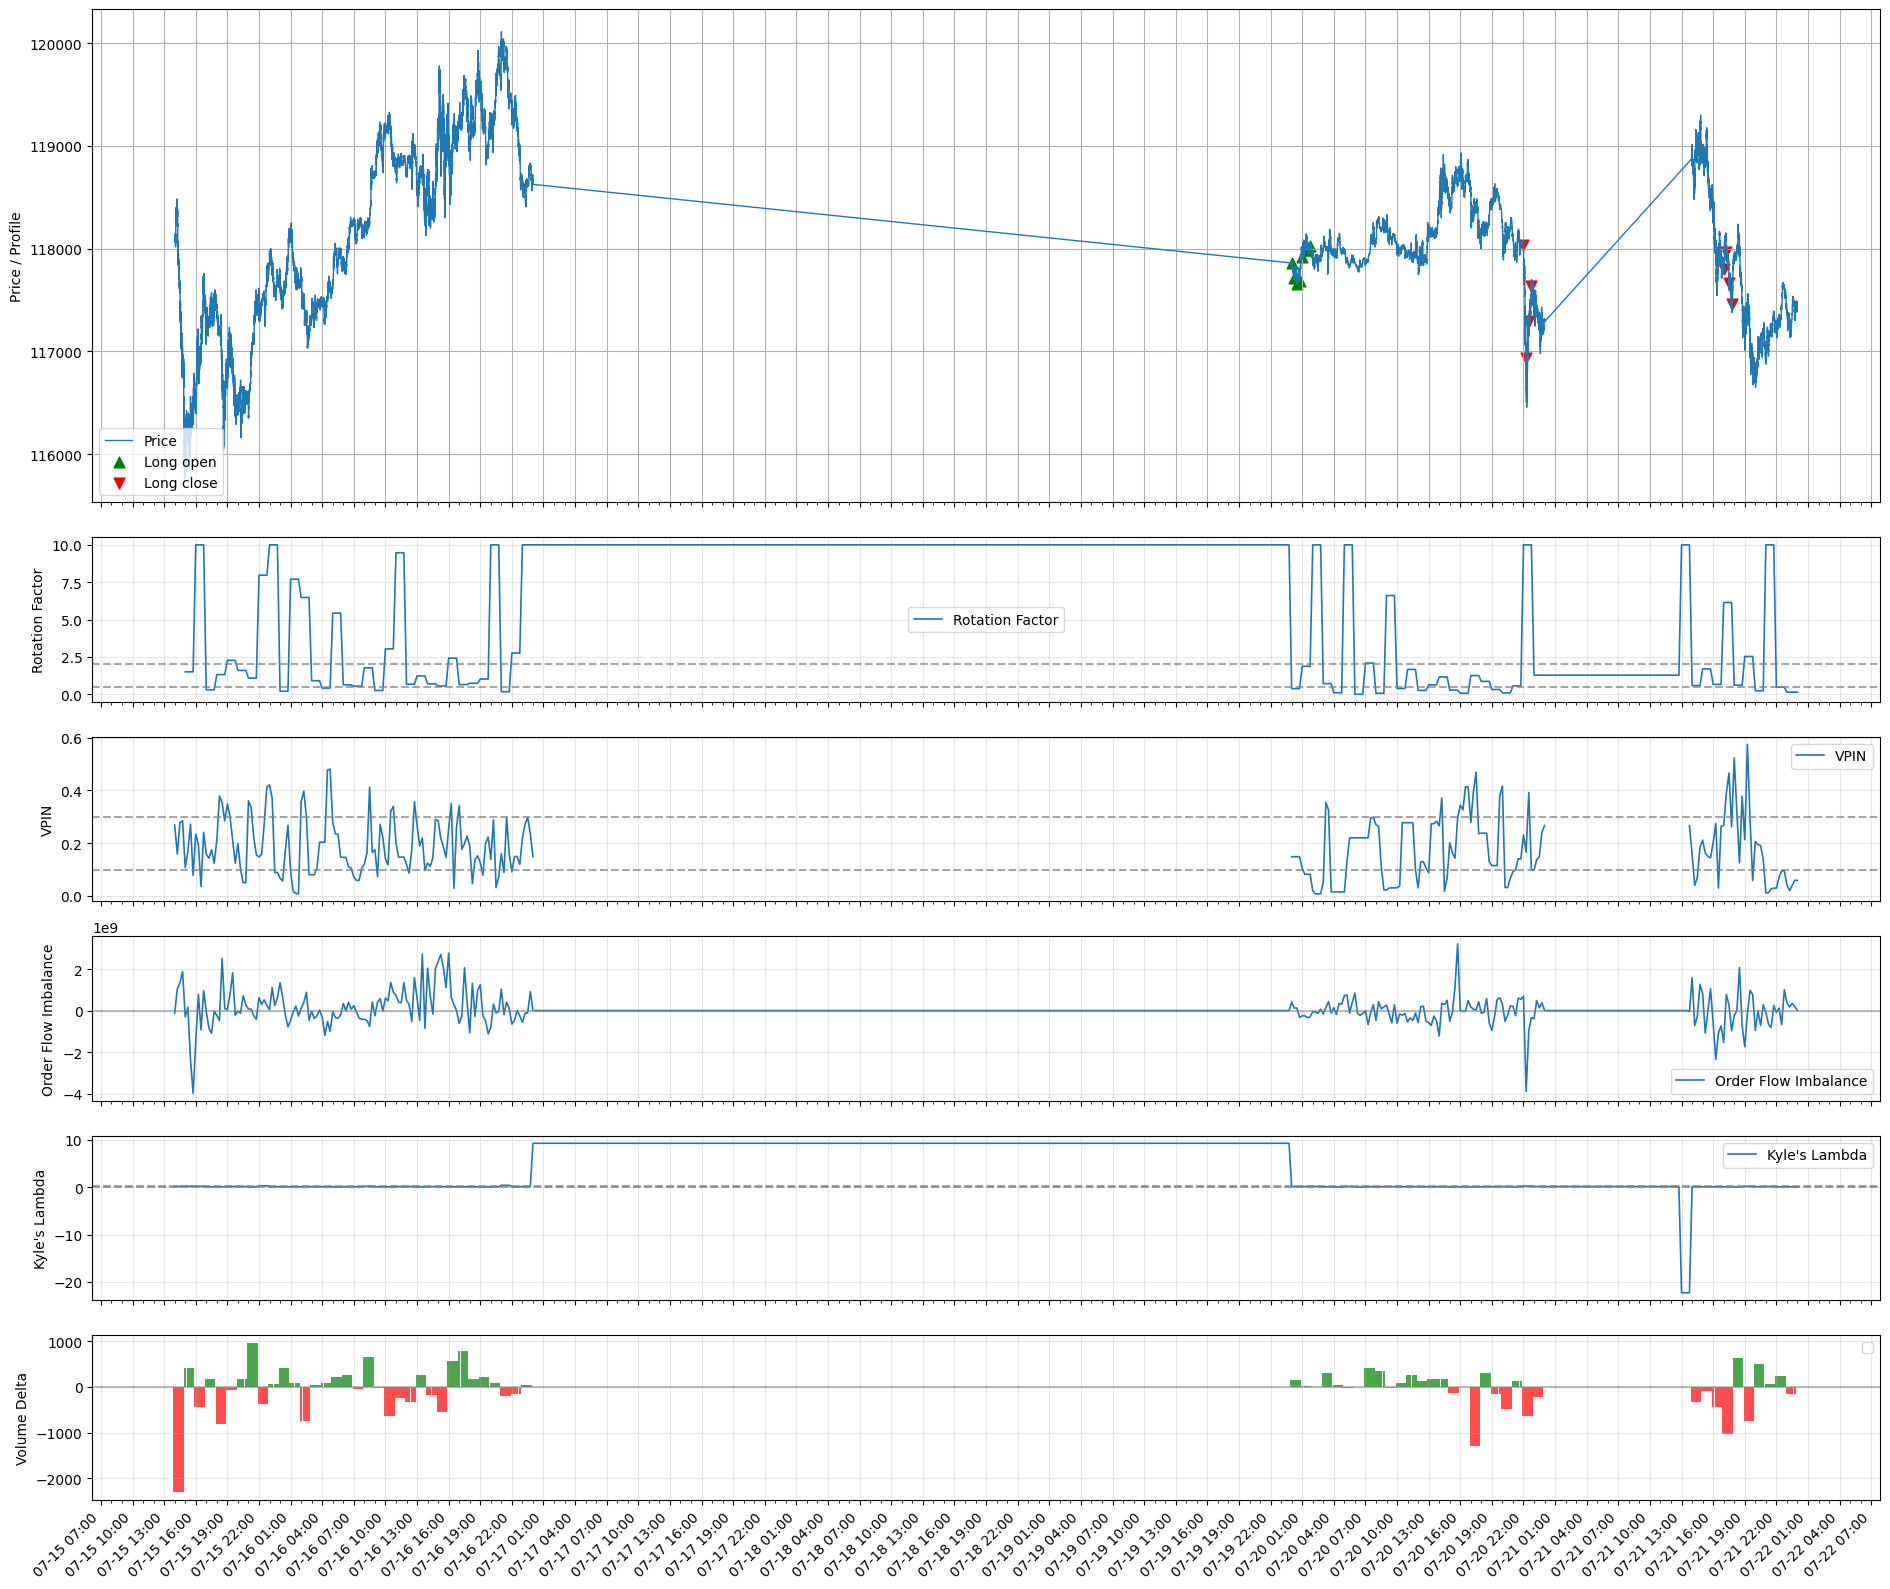

In [99]:
fig, axes = plt.subplots(
    6, 1,
    figsize=(19, 16),
    constrained_layout=True,
    sharex=True,
    gridspec_kw={'height_ratios': [3, 1, 1, 1, 1, 1]}
)
ax0 = axes[0]

# Рисуем цену
ax0.plot(df['recv_time'], df['price'], label='Price', linewidth=1)

# 1) Разделяем trades на два списка
trades_long  = [t for t in trades if t['direction'] == 'long']
trades_short = [t for t in trades if t['direction'] == 'short']

# 2) Извлекаем отдельно entry/exit времена и цены для каждого направления
long_open_times  = [t['entry_time']  for t in trades_long]
long_open_prices = [t['entry_price'] for t in trades_long]
long_close_times  = [t['exit_time']  for t in trades_long]
long_close_prices = [t['exit_price'] for t in trades_long]

short_open_times  = [t['entry_time']   for t in trades_short]
short_open_prices = [t['entry_price']  for t in trades_short]
short_close_times  = [t['exit_time']   for t in trades_short]
short_close_prices = [t['exit_price']  for t in trades_short]

# 3) Наносим на график

ax0.scatter(long_open_times,  long_open_prices,  marker='^', color='g', s=60, label='Long open')
ax0.scatter(long_close_times, long_close_prices, marker='v', color='r', s=60, label='Long close')

# ax0.scatter(short_open_times,  short_open_prices,  marker='^', color='b',      s=60, label='Short open')
# ax0.scatter(short_close_times, short_close_prices, marker='v', color='orange', s=60, label='Short close')

ax0.set_ylabel("Price / Profile")
ax0.legend(loc='lower left')
ax0.grid(True)

indicators = ['RF','VPIN','OFI','Kyle_Lambda','volume_delta']
titles = ['Rotation Factor', 'VPIN', 'Order Flow Imbalance', "Kyle's Lambda", 'Volume Delta']

for i, indicator in enumerate(indicators, start=1):
    if indicator == 'volume_delta':
        # Особый случай для volume delta - используем бары
        colors = np.where(indicators_df[indicator] >= 0, 'green', 'red')
        axes[i].bar(indicators_df.index, indicators_df[indicator], color=colors, alpha=0.7, width=0.01)
        axes[i].axhline(0, color='gray', linestyle='-', alpha=0.5)
    else:
        axes[i].plot(indicators_df.index, indicators_df[indicator], label=titles[i-1], linewidth=1.2)
    
    # Добавляем ключевые уровни для каждого индикатора
    if indicator == 'RF':
        axes[i].axhline(0.5, color='gray', linestyle='--', alpha=0.7)
        axes[i].axhline(2.0, color='gray', linestyle='--', alpha=0.7)
    elif indicator == 'VPIN':
        axes[i].axhline(0.1, color='gray', linestyle='--', alpha=0.7)
        axes[i].axhline(0.3, color='gray', linestyle='--', alpha=0.7)
    elif indicator == 'Kyle_Lambda':
        axes[i].axhline(0.05, color='gray', linestyle='--', alpha=0.7)
        axes[i].axhline(0.2, color='gray', linestyle='--', alpha=0.7)
    elif indicator == 'OFI':
        axes[i].axhline(0, color='gray', linestyle='-', alpha=0.5)
    
    axes[i].set_ylabel(titles[i-1])
    axes[i].grid(True, alpha=0.3)
    axes[i].legend(loc='best')

# Форматирование времени на последнем графике
for ax in axes:
    # 1. Устанавливаем локатор дат (каждые 3 часа)
    ax.xaxis.set_major_locator(mdates.HourLocator(interval=3))
    
    # 2. Формат с датой и временем
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d %H:%M'))
    
    # 3. Дополнительные минорные деления (каждый час)
    ax.xaxis.set_minor_locator(mdates.HourLocator(interval=1))
    
    # 4. Поворот меток
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right')

plt.subplots_adjust(bottom=0.15)  # Увеличиваем место снизу для меток времени
plt.tight_layout()
plt.show()

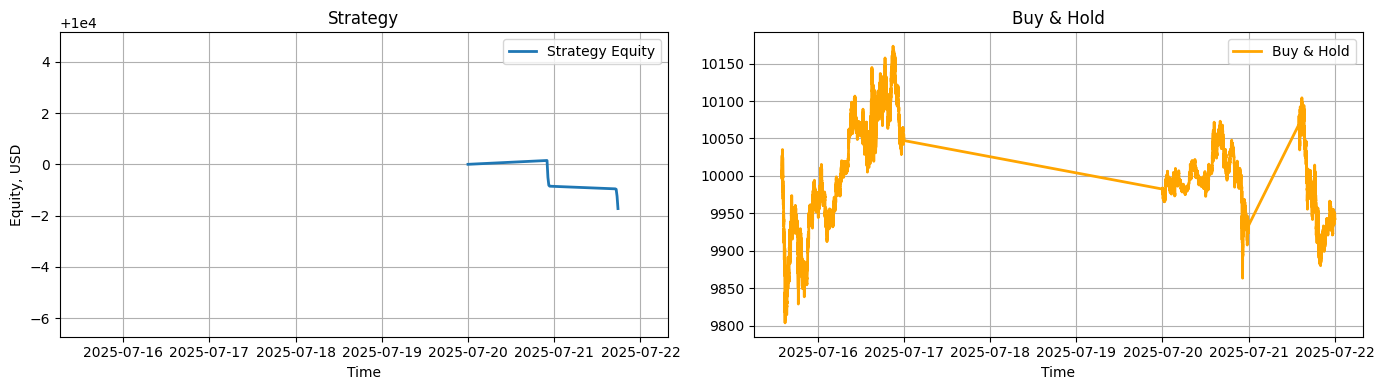

Strategy returns:
-0.00017272794958444137 %, Balance: 9998.272720504156
Buy&Hold returns:
-0.00572125503415391 %, Balance: 9942.78744965846


C:\Users\382he\AppData\Local\Temp\ipykernel_7488\2589324661.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f'Buy&Hold returns:\n{(bh_equity[-1]-bh_equity[0])/10000} %, Balance: {bh_equity[-1]}')


In [100]:
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(14,4),sharex=True, sharey=False)

# Стратегия
pts = sorted(zip(times, equity), key=lambda x: x[0])
times_sorted, equity_sorted = zip(*pts)

ax0.plot(times_sorted, equity_sorted, label='Strategy Equity', linewidth=2)
ax0.set_title("Strategy")
ax0.set_xlabel("Time")
ax0.set_ylabel("Equity, USD")
ax0.legend()
ax0.grid(True)
# Сузим диапазон Y, чтобы мелкие изменения было видно:
y_min = min(equity)*0.9995
y_max = max(equity)*1.0005
ax0.set_ylim(y_min, y_max)

# Buy & Hold
ax1.plot(bh_equity.index, bh_equity.values, 
         label='Buy & Hold', color='orange', linewidth=2)
ax1.set_title("Buy & Hold")
ax1.set_xlabel("Time")
ax1.legend()
ax1.grid(True)


plt.tight_layout()
plt.show()

print(f'Strategy returns:\n{(equity[-1]-equity[0])/10000} %, Balance: {equity[-1]}')
print(f'Buy&Hold returns:\n{(bh_equity[-1]-bh_equity[0])/10000} %, Balance: {bh_equity[-1]}')